# Compute basic stats for song "bouts" (contiguous singing periods)

In [1]:
%matplotlib inline
from itertools import product as cprod
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import sys
from scipy import signal
from scipy import stats

from aux import Objects, get_seg
from disp import set_font_size, get_line, set_color

cc = np.concatenate

BOUT_FILE = 'data/simple/behav/c_bouts.npy'
INTERBOUT_FILE = 'data/simple/behav/c_interbouts.npy'

In [2]:
bt_data = np.load(BOUT_FILE, allow_pickle=True)[0]
bts = bt_data['bouts']
FPS = bt_data['fps']
DT = 1/FPS

ibts = np.load(INTERBOUT_FILE, allow_pickle=True)[0]['interbouts']

durs = np.array([len(bt) for bt in bts])/FPS
idurs = np.array([len(ibt) for ibt in ibts])/FPS

# Load data

0 = silent, 1 = sine, 2 = pulse slow, 3 = pulse fast

Fill in momentary gaps in data

In [3]:
np.random.seed(0)

for cbt, bt in enumerate(bts):
    bt_filled = bt.copy()
    
    for iz in np.nonzero(bt == 0)[0]:  # all idxs of 0 state
        if bt_filled[iz-1] == 1:  # sine to left
            if bt_filled[iz+1] in [0, 1]:  # sine or 0 to right
                bt_filled[iz] = 1  # fill sine
            elif bt_filled[iz+1] == 2:  # pulse slow to right
                bt_filled[iz] = np.random.choice([1, 2])  # fill sine or pulse w/ 50% prob
            elif bt_filled[iz+1] == 3:  # pulse fast to right
                bt_filled[iz] = np.random.choice([1, 3])  # fill sine or pulse w/ 50% prob
        elif bt_filled[iz-1] == 2:  # pulse slow to left
            if bt_filled[iz+1] in [0, 2]:  # pulse slow or 0 to right
                bt_filled[iz] = 2  # fill pulse slow
            elif bt_filled[iz+1] == 1:  # sine to right
                bt_filled[iz] = np.random.choice([1, 2])  # fill sine or pulse slow w/ 50% prob
            elif bt_filled[iz+1] == 3:  # pulse fast to right
                bt_filled[iz] = np.random.choice([2, 3])  # fill pulse slow or pulse fast w/ 50% prob
        elif bt_filled[iz-1] == 3:  # pulse fast to left
            if bt_filled[iz+1] in [0, 3]:  # pulse fast or 0 to right
                bt_filled[iz] = 3  # fill pulse
            elif bt_filled[iz+1] == 1:  # sine to right
                bt_filled[iz] = np.random.choice([1, 3])  # fill sine or pulse fast w/ 50% prob
            elif bt_filled[iz+1] == 2:  # pulse slow to right
                bt_filled[iz] = np.random.choice([2, 3])  # fill pulse slow or pulse fast w/ 50% prob
            
    bts[cbt] = bt_filled

# Bout examples

/Users/rp21/opt/miniconda3/envs/sci/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


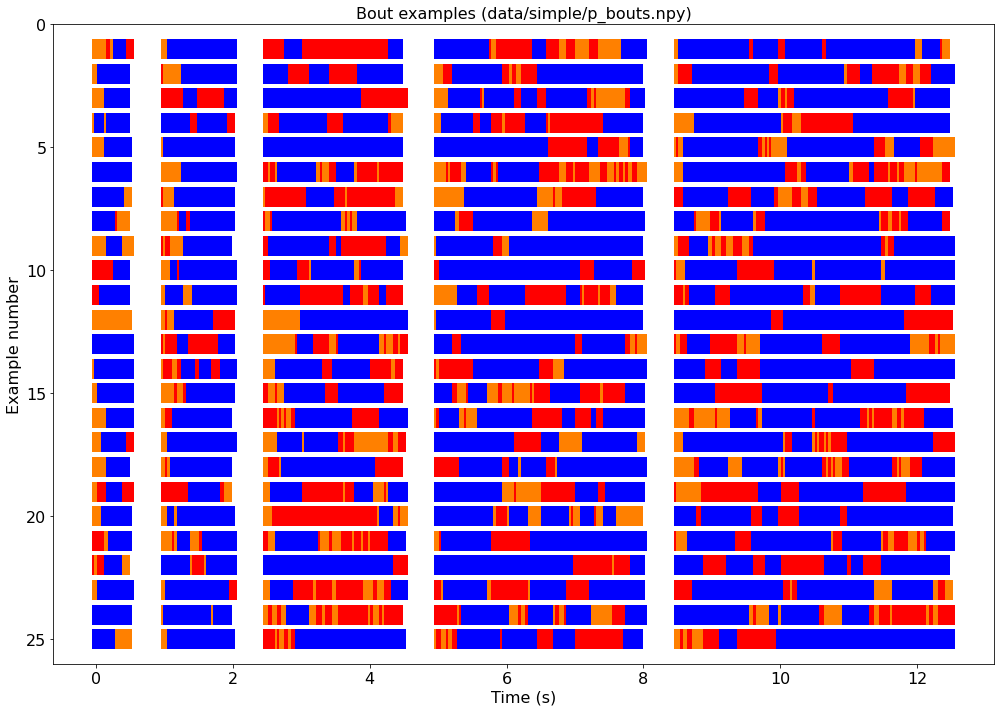

In [4]:
N_XPL = 25
DUR_RANGES = [(.45, .55), (.95, 1.05), (1.95, 2.05), (2.95, 3.05), (3.95, 4.05)]
COLOR = np.array(['gray', 'b', 'r', (1, .5, 0)])

np.random.seed(0)

fig, ax = plt.subplots(1, 1, figsize=(14, 10), tight_layout=True)
x_off = [0, 1, 2.5, 5, 8.5]

for cdr, (lb, ub) in enumerate(DUR_RANGES):
    m = (lb <= durs) & (durs < ub)
    bts_this_dur = bts[m][:N_XPL]
    np.random.shuffle(bts_this_dur)
    
    for cb, bt in enumerate(bts_this_dur):
        t = np.arange(len(bt))/FPS + x_off[cdr]
        ax.scatter(t, cb*np.ones(len(t))+1, c=COLOR[bt], marker='|', lw=8, s=400)

ax.set_ylim(N_XPL+1, 0)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Example number')
ax.set_title(f'Bout examples ({BOUT_FILE})')

set_font_size(ax, 16)

Duration distribution

45745 total bouts
1010 bouts greater than 5 seconds.
125 bouts greater than 10 seconds.


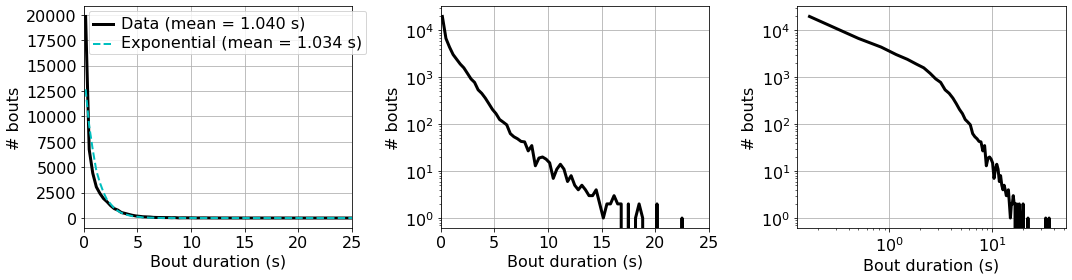

In [5]:
np.random.seed(0)

fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
bins_dur = np.linspace(0, 40, 121)
binc_dur = .5*(bins_dur[:-1] + bins_dur[1:])

ct_durs, _ = np.histogram(durs, bins=bins_dur)

durs_exp = np.random.exponential(durs.mean(), len(durs))
ct_durs_exp, _ = np.histogram(durs_exp, bins=bins_dur)

axs[0].plot(binc_dur, ct_durs, c='k', lw=3)
axs[0].plot(binc_dur, ct_durs_exp, c='c', lw=2, ls='--')
axs[0].set_xlim(0, 25)

axs[0].set_xlabel('Bout duration (s)')
axs[0].set_ylabel('# bouts')
axs[0].legend([f'Data (mean = {np.mean(durs):.3f} s)', f'Exponential (mean = {np.mean(durs_exp):.3f} s)'])

axs[1].semilogy(binc_dur, ct_durs, c='k', lw=3)
#axs[1].semilogy(binc_dur, ct_durs_exp, c='c', lw=2, ls='--')
axs[1].set_xlim(0, 25)

axs[1].set_xlabel('Bout duration (s)')
axs[1].set_ylabel('# bouts')

axs[2].loglog(binc_dur, ct_durs, c='k', lw=3)
#axs[2].loglog(binc_dur, ct_durs_exp, c='c', lw=2, ls='--')

axs[2].set_xlabel('Bout duration (s)')
axs[2].set_ylabel('# bouts')

axs[0].grid()
axs[1].grid()
axs[2].grid()
set_font_size(axs, 16)

print(f'{len(durs)} total bouts')
print(f'{np.sum(durs > 5)} bouts greater than 5 seconds.')
print(f'{np.sum(durs > 10)} bouts greater than 10 seconds.')

Interbout durations

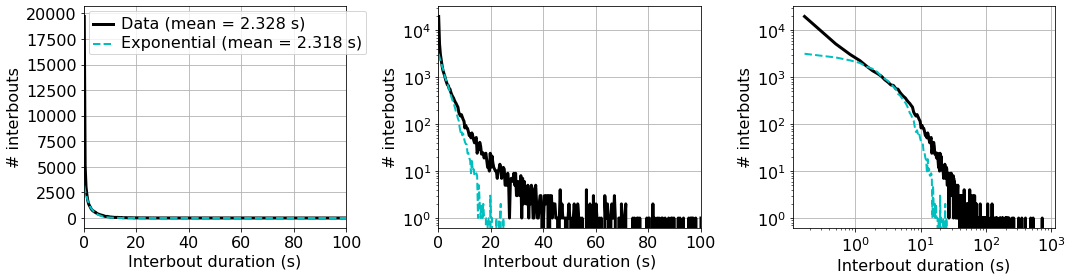

In [6]:
np.random.seed(0)

fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
bins_idur = np.linspace(0, 750, 2251)
binc_idur = .5*(bins_idur[:-1] + bins_idur[1:])

ct_idurs, _ = np.histogram(idurs[idurs > .04], bins=bins_idur)

idurs_exp = np.random.exponential(idurs[idurs > .04].mean(), len(idurs[idurs > .5]))
ct_idurs_exp, _ = np.histogram(idurs_exp, bins=bins_idur)

axs[0].plot(binc_idur, ct_idurs, c='k', lw=3)
axs[0].plot(binc_idur, ct_idurs_exp, c='c', lw=2, ls='--')
axs[0].set_xlim(0, 100)

axs[0].set_xlabel('Interbout duration (s)')
axs[0].set_ylabel('# interbouts')
axs[0].legend([f'Data (mean = {np.mean(idurs):.3f} s)', f'Exponential (mean = {np.mean(idurs_exp):.3f} s)'])

axs[1].semilogy(binc_idur, ct_idurs, c='k', lw=3)
axs[1].semilogy(binc_idur, ct_idurs_exp, c='c', lw=2, ls='--')
axs[1].set_xlim(0, 100)

axs[1].set_xlabel('Interbout duration (s)')
axs[1].set_ylabel('# interbouts')

axs[2].loglog(binc_idur, ct_idurs, c='k', lw=3)
axs[2].loglog(binc_idur, ct_idurs_exp, c='c', lw=2, ls='--')

axs[2].set_xlabel('Interbout duration (s)')
axs[2].set_ylabel('# interbouts')

axs[0].grid()
axs[1].grid()
axs[2].grid()
set_font_size(axs, 16)

# Mode segment statistics

In [7]:
MIN_GAP = int(round(.075/DT))  # TO DO: set MIN_GAP according to time it takes wing to fold back

sin_durs_split = np.repeat(None, len(bts))
psl_durs_split = np.repeat(None, len(bts))
pfs_durs_split = np.repeat(None, len(bts))

for cbt, bt in enumerate(bts):
    sin_seg, sin_bds = get_seg(bt==1, MIN_GAP)
    if len(sin_bds) > 0:
        sin_durs_split[cbt] = (sin_bds[:, 1] - sin_bds[:, 0]) / FPS
    else:
        sin_durs_split[cbt] = np.array([])
    
    psl_seg, psl_bds = get_seg(bt==2, MIN_GAP)
    if len(psl_bds) > 0:
        psl_durs_split[cbt] = (psl_bds[:, 1] - psl_bds[:, 0]) / FPS
    else:
        psl_durs_split[cbt] = np.array([])
        
    pfs_seg, pfs_bds = get_seg(bt==3, MIN_GAP)
    if len(pfs_bds) > 0:
        pfs_durs_split[cbt] = (pfs_bds[:, 1] - pfs_bds[:, 0]) / FPS
    else:
        pfs_durs_split[cbt] = np.array([])
        
n_sin = np.array([len(sin_durs_) for sin_durs_ in sin_durs_split])
n_psl = np.array([len(psl_durs_) for psl_durs_ in psl_durs_split])
n_pfs = np.array([len(pfs_durs_) for pfs_durs_ in pfs_durs_split])

n_seg = n_sin + n_psl + n_pfs

Total, start and end mode probability

Text(2, 0.425, '0.379')

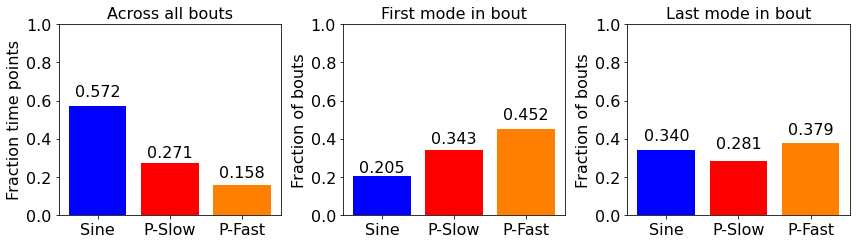

In [8]:
sin_total = np.sum([(bt == 1).sum() for bt in bts])
psl_total = np.sum([(bt == 2).sum() for bt in bts])
pfs_total = np.sum([(bt == 3).sum() for bt in bts])

p_total_sin = sin_total / (sin_total + psl_total + pfs_total)
p_total_psl = psl_total / (sin_total + psl_total + pfs_total)
p_total_pfs = pfs_total / (sin_total + psl_total + pfs_total)

mode_start = np.array([bt[0] for bt in bts])
mode_end = np.array([bt[-1] for bt in bts])

p_start_sin = np.mean(mode_start==1)
p_start_psl = np.mean(mode_start==2)
p_start_pfs = np.mean(mode_start==3)

p_end_sin = np.mean(mode_end==1)
p_end_psl = np.mean(mode_end==2)
p_end_pfs = np.mean(mode_end==3)

fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), tight_layout=True)
axs[0].bar(range(3), [p_total_sin, p_total_psl, p_total_pfs], color=['b', 'r', (1, .5, 0)])
axs[0].set_title('Across all bouts')

axs[1].bar(range(3), [p_start_sin, p_start_psl, p_start_pfs], color=['b', 'r', (1, .5, 0)])
axs[1].set_title('First mode in bout')

axs[2].bar(range(3), [p_end_sin, p_end_psl, p_end_pfs], color=['b', 'r', (1, .5, 0)])
axs[2].set_title('Last mode in bout')

for ca, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Sine', 'P-Slow', 'P-Fast'])
    if ca == 0:
        ax.set_ylabel('Fraction time points')
    else:
        ax.set_ylabel('Fraction of bouts')
    
set_font_size(axs, 16)

axs[0].text(0, .625, f'{p_total_sin:.3f}', ha='center', fontsize=16)
axs[0].text(1, .3, f'{p_total_psl:.3f}', ha='center', fontsize=16)
axs[0].text(2, .2, f'{p_total_pfs:.3f}', ha='center', fontsize=16)

axs[1].text(0, .225, f'{p_start_sin:.3f}', ha='center', fontsize=16)
axs[1].text(1, .375, f'{p_start_psl:.3f}', ha='center', fontsize=16)
axs[1].text(2, .5, f'{p_start_pfs:.3f}', ha='center', fontsize=16)

axs[2].text(0, .39, f'{p_end_sin:.3f}', ha='center', fontsize=16)
axs[2].text(1, .35, f'{p_end_psl:.3f}', ha='center', fontsize=16)
axs[2].text(2, .425, f'{p_end_pfs:.3f}', ha='center', fontsize=16)

Number of segments per bout

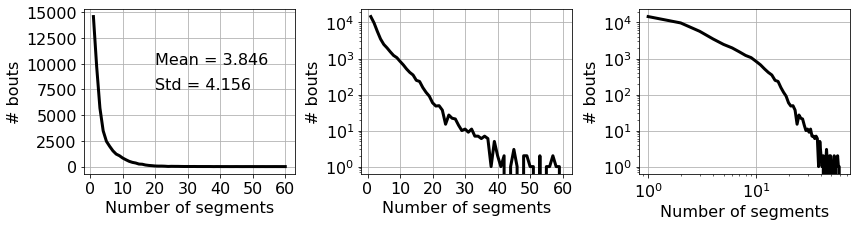

In [9]:
bins_n_seg = np.linspace(.5, 60.5, 61)
binc_n_seg = .5*(bins_n_seg[:-1] + bins_n_seg[1:])

ct_n_seg, _ = np.histogram(n_seg, bins_n_seg)

fig, axs = plt.subplots(1, 3, figsize=(12, 3.25), tight_layout=True)
axs[0].plot(binc_n_seg, ct_n_seg, lw=3, c='k')

axs[0].set_xlabel('Number of segments')
axs[0].set_ylabel('# bouts')

axs[0].text(20, 10000, f'Mean = {n_seg.mean():.3f}', fontsize=16)
axs[0].text(20, 7500, f'Std = {n_seg.std():.3f}', fontsize=16)

axs[1].semilogy(binc_n_seg, ct_n_seg, lw=3, c='k')

axs[1].set_xlabel('Number of segments')
axs[1].set_ylabel('# bouts')

axs[2].loglog(binc_n_seg, ct_n_seg, lw=3, c='k')

axs[2].set_xlabel('Number of segments')
axs[2].set_ylabel('# bouts')

set_font_size(axs, 16)
for ax in axs:
    ax.grid()